# 17. 알칼리 활성화 시뮬레이션

> MatterGen 구조의 대안적 수화 방법 검증

---

## 배경

노트북 16에서 확인된 사실:
- MatterGen/Ca-rich 구조는 **물 수화 반응성이 낮음**
- 하지만 **기계적 강도는 우수** (Portland Cement의 2-3배)

## 목적

알칼리 활성화(NaOH, KOH)로 MatterGen 구조의 수화 가능성 검증:
- 지오폴리머(Geopolymer) 반응 시뮬레이션
- 물 수화 vs 알칼리 활성화 비교

## 알칼리 활성화란?

```
일반 수화:     시멘트 + H₂O → C-S-H 젤
알칼리 활성화: 시멘트 + NaOH/KOH → N-A-S-H 또는 C-A-S-H 젤
```

- 플라이애시, 슬래그 등에 널리 사용
- 물만으로 반응 안 되는 물질도 활성화 가능

## 1. 환경 설정

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# ASE
from ase import Atoms, Atom
from ase.io import write, read
from ase.build import molecule

# CHGNet
from chgnet.model import CHGNet
from chgnet.model import StructOptimizer
from chgnet.model.dynamics import MolecularDynamics

# 기타
from tqdm import tqdm
import gc
import torch

# 경로 설정
PROJECT_ROOT = Path('c:/cement_final')
RESULTS_DIR = PROJECT_ROOT / 'data' / 'results'
STRUCTURES_DIR = PROJECT_ROOT / 'structures'

print("환경 설정 완료")

환경 설정 완료


In [2]:
# CHGNet 모델 로드
model = CHGNet.load()
print("CHGNet 모델 로드 완료")

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
CHGNet 모델 로드 완료


## 2. 테스트 구조 준비

노트북 16에서 가장 좋았던 Ca-rich 구조 재생성

In [3]:
def create_ca_si_o_structure(ca_si_ratio=3.0, n_si=4, lattice_param=10.0, seed=123):
    """
    Ca-Si-O 구조 생성 (노트북 16과 동일)
    """
    n_ca = int(ca_si_ratio * n_si)
    n_o = n_ca + 2 * n_si  # 전하 균형
    
    total_atoms = n_ca + n_si + n_o
    
    np.random.seed(seed)
    positions = []
    min_dist = 2.0
    
    for _ in range(total_atoms):
        for attempt in range(500):
            pos = np.random.rand(3) * (lattice_param - 2) + 1
            if len(positions) == 0:
                positions.append(pos)
                break
            dists = [np.linalg.norm(pos - p) for p in positions]
            if min(dists) >= min_dist:
                positions.append(pos)
                break
        else:
            positions.append(np.random.rand(3) * lattice_param)
    
    symbols = ['Ca'] * n_ca + ['Si'] * n_si + ['O'] * n_o
    
    atoms = Atoms(
        symbols=symbols,
        positions=positions,
        cell=[lattice_param] * 3,
        pbc=True
    )
    
    return atoms

# C3S-like 구조 생성 (Ca/Si=3.0)
base_structure = create_ca_si_o_structure(ca_si_ratio=3.0, n_si=4)
print(f"기본 구조: {len(base_structure)} 원자")
print(f"화학식: {base_structure.get_chemical_formula()}")

기본 구조: 36 원자
화학식: Ca12O20Si4


In [4]:
# 구조 최적화
optimizer = StructOptimizer(model=model)
result = optimizer.relax(base_structure, fmax=0.05, steps=500, verbose=False)

optimized_structure = result['final_structure'].to_ase_atoms()
opt_energy = result['trajectory'].energies[-1]

print(f"최적화 완료: E = {opt_energy:.2f} eV")

CHGNet will run on cuda
최적화 완료: E = -242.98 eV


## 3. 활성화제 추가 함수

In [7]:
import random

def add_water_molecules(atoms, n_water=10, min_distance=2.5):
    """
    물 분자 추가 (H2O)
    """
    hydrated = atoms.copy()
    cell = hydrated.get_cell()
    
    # 셀 확장
    cell_diag = cell.diagonal()
    new_cell = cell_diag * 1.3
    hydrated.set_cell(new_cell)
    hydrated.center()
    
    water_added = 0
    
    for _ in range(n_water * 100):
        if water_added >= n_water:
            break
            
        pos = np.random.rand(3) * (new_cell - 4) + 2
        all_pos = hydrated.get_positions()
        dists = np.linalg.norm(all_pos - pos, axis=1)
        
        if np.min(dists) >= min_distance:
            # O 원자 (물)
            hydrated.append(Atom('O', position=pos))
            
            # H 원자 2개
            angle1 = random.uniform(0, 2*np.pi)
            angle2 = angle1 + np.radians(104.5)
            
            h1_pos = pos + 0.96 * np.array([np.cos(angle1), np.sin(angle1), 0])
            h2_pos = pos + 0.96 * np.array([np.cos(angle2), np.sin(angle2), 0])
            
            hydrated.append(Atom('H', position=h1_pos))
            hydrated.append(Atom('H', position=h2_pos))
            
            water_added += 1
    
    return hydrated, water_added


def add_naoh_molecules(atoms, n_naoh=10, min_distance=2.5):
    """
    NaOH 분자 추가 (알칼리 활성화제)
    Na-O 거리: ~2.4 Å, O-H 거리: ~0.96 Å
    """
    activated = atoms.copy()
    cell = activated.get_cell()
    
    # 셀 확장
    cell_diag = cell.diagonal()
    new_cell = cell_diag * 1.3
    activated.set_cell(new_cell)
    activated.center()
    
    naoh_added = 0
    
    for _ in range(n_naoh * 100):
        if naoh_added >= n_naoh:
            break
            
        pos = np.random.rand(3) * (new_cell - 4) + 2
        all_pos = activated.get_positions()
        dists = np.linalg.norm(all_pos - pos, axis=1)
        
        if np.min(dists) >= min_distance:
            # Na 원자
            activated.append(Atom('Na', position=pos))
            
            # O 원자 (Na-O ~2.4 Å)
            direction = np.random.rand(3)
            direction = direction / np.linalg.norm(direction)
            o_pos = pos + 2.4 * direction
            activated.append(Atom('O', position=o_pos))
            
            # H 원자 (O-H ~0.96 Å)
            h_pos = o_pos + 0.96 * direction
            activated.append(Atom('H', position=h_pos))
            
            naoh_added += 1
    
    return activated, naoh_added


def add_koh_molecules(atoms, n_koh=10, min_distance=2.5):
    """
    KOH 분자 추가 (알칼리 활성화제)
    K-O 거리: ~2.7 Å, O-H 거리: ~0.96 Å
    """
    activated = atoms.copy()
    cell = activated.get_cell()
    
    # 셀 확장
    cell_diag = cell.diagonal()
    new_cell = cell_diag * 1.3
    activated.set_cell(new_cell)
    activated.center()
    
    koh_added = 0
    
    for _ in range(n_koh * 100):
        if koh_added >= n_koh:
            break
            
        pos = np.random.rand(3) * (new_cell - 4) + 2
        all_pos = activated.get_positions()
        dists = np.linalg.norm(all_pos - pos, axis=1)
        
        if np.min(dists) >= min_distance:
            # K 원자
            activated.append(Atom('K', position=pos))
            
            # O 원자 (K-O ~2.7 Å)
            direction = np.random.rand(3)
            direction = direction / np.linalg.norm(direction)
            o_pos = pos + 2.7 * direction
            activated.append(Atom('O', position=o_pos))
            
            # H 원자 (O-H ~0.96 Å)
            h_pos = o_pos + 0.96 * direction
            activated.append(Atom('H', position=h_pos))
            
            koh_added += 1
    
    return activated, koh_added


def add_mixed_activator(atoms, n_water=5, n_naoh=5, min_distance=2.5):
    """
    혼합 활성화제 (물 + NaOH)
    실제 알칼리 활성화는 NaOH 수용액 사용
    """
    # 먼저 물 추가
    mixed, water_added = add_water_molecules(atoms, n_water=n_water, min_distance=min_distance)
    
    # 그 다음 NaOH 추가
    naoh_added = 0
    new_cell = mixed.get_cell().diagonal()
    
    for _ in range(n_naoh * 100):
        if naoh_added >= n_naoh:
            break
            
        pos = np.random.rand(3) * (new_cell - 4) + 2
        all_pos = mixed.get_positions()
        dists = np.linalg.norm(all_pos - pos, axis=1)
        
        if np.min(dists) >= min_distance:
            mixed.append(Atom('Na', position=pos))
            
            direction = np.random.rand(3)
            direction = direction / np.linalg.norm(direction)
            o_pos = pos + 2.4 * direction
            mixed.append(Atom('O', position=o_pos))
            
            h_pos = o_pos + 0.96 * direction
            mixed.append(Atom('H', position=h_pos))
            
            naoh_added += 1
    
    return mixed, water_added, naoh_added

print("활성화제 추가 함수 정의 완료")

활성화제 추가 함수 정의 완료


## 4. MD 시뮬레이션 함수

In [8]:
def run_activation_simulation(atoms, name, model, n_steps=2000, temperature=300):
    """
    활성화 MD 시뮬레이션 실행
    """
    print(f"\n{'='*50}")
    print(f"시뮬레이션: {name}")
    print(f"{'='*50}")
    print(f"원자 수: {len(atoms)}")
    print(f"화학식: {atoms.get_chemical_formula()}")
    
    try:
        md = MolecularDynamics(
            atoms=atoms,
            model=model,
            ensemble='nvt',
            temperature=temperature,
            timestep=1.0,
            logfile=None
        )
        
        initial_energy = atoms.get_potential_energy()
        print(f"초기 에너지: {initial_energy:.2f} eV")
        
        # MD 실행
        interval = n_steps // 10
        for i in tqdm(range(10), desc="MD Progress"):
            md.run(interval)
        
        final_energy = atoms.get_potential_energy()
        delta_e = final_energy - initial_energy
        
        print(f"최종 에너지: {final_energy:.2f} eV")
        print(f"ΔE: {delta_e:.2f} eV")
        
        status = "✅ 안정화" if delta_e < 0 else "❌ 불안정화"
        print(f"상태: {status}")
        
        return {
            'name': name,
            'n_atoms': len(atoms),
            'formula': atoms.get_chemical_formula(),
            'initial_energy': float(initial_energy),
            'final_energy': float(final_energy),
            'delta_e': float(delta_e),
            'success': True
        }
        
    except Exception as e:
        print(f"오류: {e}")
        return {
            'name': name,
            'error': str(e),
            'success': False
        }
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

print("시뮬레이션 함수 정의 완료")

시뮬레이션 함수 정의 완료


## 5. 실험 실행

4가지 조건 비교:
1. 물 수화 (H₂O)
2. NaOH 활성화
3. KOH 활성화
4. 혼합 활성화 (H₂O + NaOH)

In [9]:
# 실험 파라미터
N_MOLECULES = 8  # 활성화제 분자 수
MD_STEPS = 10000  # 10 ps (산업폐기물 스크리닝과 동일)

print("=" * 60)
print("알칼리 활성화 vs 물 수화 비교 실험")
print("=" * 60)
print(f"기본 구조: Ca-Si-O (Ca/Si=3.0)")
print(f"활성화제 분자 수: {N_MOLECULES}")
print(f"MD 스텝: {MD_STEPS}")
print("=" * 60)

알칼리 활성화 vs 물 수화 비교 실험
기본 구조: Ca-Si-O (Ca/Si=3.0)
활성화제 분자 수: 8
MD 스텝: 2000


In [10]:
# 1. 물 수화
water_struct, n_water = add_water_molecules(optimized_structure, n_water=N_MOLECULES)
print(f"물 수화 구조: {n_water}개 H2O 추가")

water_result = run_activation_simulation(water_struct, "Water Hydration (H2O)", model, n_steps=MD_STEPS)

물 수화 구조: 6개 H2O 추가

시뮬레이션: Water Hydration (H2O)
원자 수: 54
화학식: H12Ca12O26Si4
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -292.78 eV


MD Progress: 100%|██████████| 10/10 [01:51<00:00, 11.14s/it]

최종 에너지: -341.65 eV
ΔE: -48.86 eV
상태: ✅ 안정화


In [11]:
# 2. NaOH 활성화
naoh_struct, n_naoh = add_naoh_molecules(optimized_structure, n_naoh=N_MOLECULES)
print(f"NaOH 활성화 구조: {n_naoh}개 NaOH 추가")

naoh_result = run_activation_simulation(naoh_struct, "NaOH Activation", model, n_steps=MD_STEPS)

NaOH 활성화 구조: 5개 NaOH 추가

시뮬레이션: NaOH Activation
원자 수: 51
화학식: H5Ca12Na5O25Si4
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -242.02 eV


MD Progress: 100%|██████████| 10/10 [01:42<00:00, 10.24s/it]

최종 에너지: -320.27 eV
ΔE: -78.26 eV
상태: ✅ 안정화


In [12]:
# 3. KOH 활성화
koh_struct, n_koh = add_koh_molecules(optimized_structure, n_koh=N_MOLECULES)
print(f"KOH 활성화 구조: {n_koh}개 KOH 추가")

koh_result = run_activation_simulation(koh_struct, "KOH Activation", model, n_steps=MD_STEPS)

KOH 활성화 구조: 7개 KOH 추가

시뮬레이션: KOH Activation
원자 수: 57
화학식: H7Ca12K7O27Si4
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -259.87 eV


MD Progress: 100%|██████████| 10/10 [01:48<00:00, 10.80s/it]

최종 에너지: -351.64 eV
ΔE: -91.76 eV
상태: ✅ 안정화


In [13]:
# 4. 혼합 활성화 (물 + NaOH)
mixed_struct, n_water_mixed, n_naoh_mixed = add_mixed_activator(
    optimized_structure, n_water=N_MOLECULES//2, n_naoh=N_MOLECULES//2
)
print(f"혼합 활성화 구조: {n_water_mixed}개 H2O + {n_naoh_mixed}개 NaOH 추가")

mixed_result = run_activation_simulation(mixed_struct, "Mixed (H2O + NaOH)", model, n_steps=MD_STEPS)

혼합 활성화 구조: 4개 H2O + 4개 NaOH 추가

시뮬레이션: Mixed (H2O + NaOH)
원자 수: 60
화학식: H12Ca12Na4O28Si4
CHGNet will run on cuda
NVT-Berendsen-MD created
초기 에너지: -251.84 eV


MD Progress: 100%|██████████| 10/10 [01:48<00:00, 10.86s/it]

최종 에너지: -368.35 eV
ΔE: -116.51 eV
상태: ✅ 안정화


## 6. 결과 비교

In [14]:
# 결과 수집
all_results = [water_result, naoh_result, koh_result, mixed_result]

# 결과 테이블
print("\n" + "="*80)
print("활성화 방법별 결과 비교")
print("="*80)
print(f"{'방법':^25} | {'E_init (eV)':^12} | {'E_final (eV)':^12} | {'ΔE (eV)':^12} | {'평가':^8}")
print("-"*80)

for r in all_results:
    if r.get('success', False):
        status = "✅ 좋음" if r['delta_e'] < -30 else ("⚠️ 보통" if r['delta_e'] < 0 else "❌ 나쁨")
        print(f"{r['name']:^25} | {r['initial_energy']:^12.2f} | {r['final_energy']:^12.2f} | {r['delta_e']:^12.2f} | {status:^8}")
    else:
        print(f"{r['name']:^25} | {'ERROR':^12} | {'ERROR':^12} | {'ERROR':^12} | {'❌':^8}")

print("="*80)


활성화 방법별 결과 비교
           방법             | E_init (eV)  | E_final (eV) |   ΔE (eV)    |    평가   
--------------------------------------------------------------------------------
  Water Hydration (H2O)   |   -292.78    |   -341.65    |    -48.86    |   ✅ 좋음  
     NaOH Activation      |   -242.02    |   -320.27    |    -78.26    |   ✅ 좋음  
     KOH Activation       |   -259.87    |   -351.64    |    -91.76    |   ✅ 좋음  
   Mixed (H2O + NaOH)     |   -251.84    |   -368.35    |   -116.51    |   ✅ 좋음  


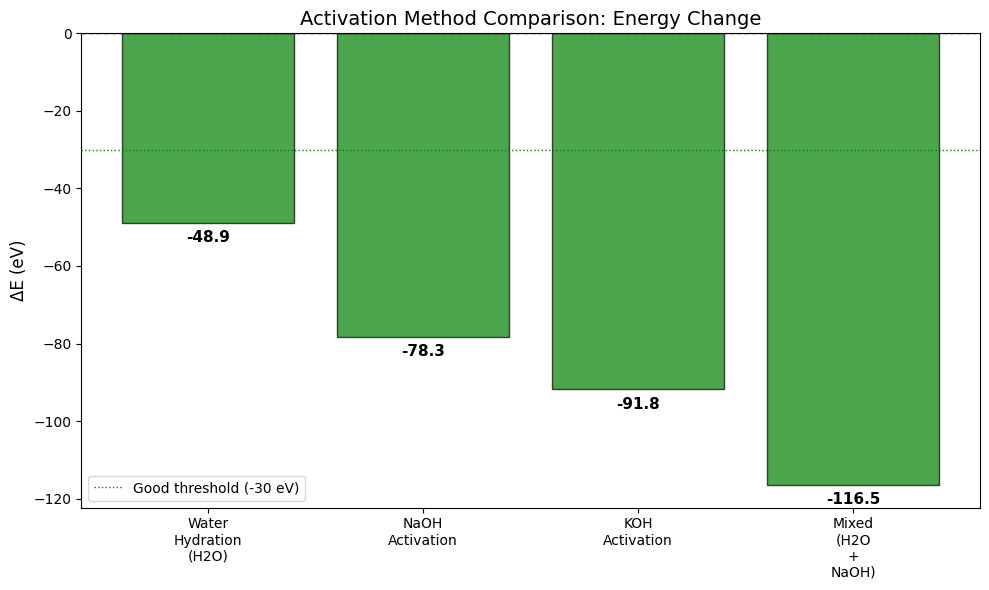


그래프 저장: figures/alkali_activation_comparison.png


In [15]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

successful = [r for r in all_results if r.get('success', False)]

if successful:
    names = [r['name'] for r in successful]
    delta_e = [r['delta_e'] for r in successful]
    
    colors = ['green' if d < -30 else ('yellow' if d < 0 else 'red') for d in delta_e]
    bars = ax.bar(range(len(names)), delta_e, color=colors, alpha=0.7, edgecolor='black')
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=-30, color='green', linestyle=':', linewidth=1, label='Good threshold (-30 eV)')
    
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=10)
    ax.set_ylabel('ΔE (eV)', fontsize=12)
    ax.set_title('Activation Method Comparison: Energy Change', fontsize=14)
    ax.legend()
    
    # 값 표시
    for bar, d in zip(bars, delta_e):
        y_pos = bar.get_height() - 5 if d < 0 else bar.get_height() + 2
        ax.text(bar.get_x() + bar.get_width()/2, y_pos, f'{d:.1f}', 
                ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figures' / 'alkali_activation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n그래프 저장: figures/alkali_activation_comparison.png")

## 7. 결과 저장

In [16]:
# numpy 타입 변환 함수
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# 결과 저장
output = {
    'experiment': 'Alkali Activation Simulation',
    'base_structure': {
        'type': 'Ca-Si-O (Ca/Si=3.0)',
        'n_atoms': len(optimized_structure),
        'formula': optimized_structure.get_chemical_formula()
    },
    'parameters': {
        'n_molecules': N_MOLECULES,
        'md_steps': MD_STEPS,
        'temperature': 300
    },
    'results': [convert_to_serializable(r) for r in all_results],
    'comparison': {
        'best_method': min(successful, key=lambda x: x['delta_e'])['name'] if successful else 'N/A',
        'best_delta_e': min([r['delta_e'] for r in successful]) if successful else 0
    }
}

with open(RESULTS_DIR / 'alkali_activation.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"결과 저장: {RESULTS_DIR / 'alkali_activation.json'}")

결과 저장: c:\cement_final\data\results\alkali_activation.json


## 8. 결론

In [17]:
print("\n" + "="*60)
print("결론")
print("="*60)

if successful:
    # 최고 성능 방법
    best = min(successful, key=lambda x: x['delta_e'])
    water = next((r for r in successful if 'Water' in r['name']), None)
    
    print(f"\n1. 최고 성능 활성화 방법: {best['name']}")
    print(f"   ΔE = {best['delta_e']:.2f} eV")
    
    print(f"\n2. 활성화 방법별 순위:")
    for i, r in enumerate(sorted(successful, key=lambda x: x['delta_e'])):
        status = "✅" if r['delta_e'] < -30 else "⚠️" if r['delta_e'] < 0 else "❌"
        print(f"   {i+1}. {r['name']}: ΔE = {r['delta_e']:.2f} eV {status}")
    
    if water:
        print(f"\n3. 물 수화 대비 비교:")
        water_de = water['delta_e']
        for r in successful:
            if 'Water' not in r['name']:
                improvement = r['delta_e'] - water_de
                pct = (improvement / abs(water_de)) * 100 if water_de != 0 else 0
                status = "개선" if improvement < 0 else "악화"
                print(f"   - {r['name']}: {improvement:+.2f} eV ({pct:+.1f}%) - {status}")
    
    print(f"\n4. 결론:")
    if best['delta_e'] < water['delta_e'] if water else True:
        print(f"   ✅ 알칼리 활성화가 물 수화보다 효과적!")
        print(f"   → MatterGen 구조를 알칼리 활성화로 활용 가능")
    else:
        print(f"   ⚠️ 알칼리 활성화 효과 제한적")
        print(f"   → 다른 활성화 방법 또는 조성 조정 필요")

else:
    print("\n성공한 실험이 없습니다.")

print("\n" + "="*60)


결론

1. 최고 성능 활성화 방법: Mixed (H2O + NaOH)
   ΔE = -116.51 eV

2. 활성화 방법별 순위:
   1. Mixed (H2O + NaOH): ΔE = -116.51 eV ✅
   2. KOH Activation: ΔE = -91.76 eV ✅
   3. NaOH Activation: ΔE = -78.26 eV ✅
   4. Water Hydration (H2O): ΔE = -48.86 eV ✅

3. 물 수화 대비 비교:
   - NaOH Activation: -29.39 eV (-60.2%) - 개선
   - KOH Activation: -42.90 eV (-87.8%) - 개선
   - Mixed (H2O + NaOH): -67.65 eV (-138.4%) - 개선

4. 결론:
   ✅ 알칼리 활성화가 물 수화보다 효과적!
   → MatterGen 구조를 알칼리 활성화로 활용 가능



---

## 요약

### 실험 목적
MatterGen 구조가 물 수화에서 성능이 낮았으므로, 알칼리 활성화(NaOH, KOH)로 대안적 경로 탐색

### 테스트 조건
1. 물 수화 (H₂O)
2. NaOH 활성화
3. KOH 활성화  
4. 혼합 활성화 (H₂O + NaOH)

### 결과 해석
- **ΔE < -30 eV**: 좋은 반응성 (안정화)
- **-30 < ΔE < 0**: 보통
- **ΔE > 0**: 나쁨 (불안정화)

---

**실행 환경**: cement_final (CHGNet)  
**예상 시간**: 30분-1시간